In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.linalg as linalg
import scipy.io.wavfile as wave
import numpy.fft
from IPython.display import Audio

In [2]:
# returns sampling frequency and audio data in range [-1, 1]. prints audio length and sample rate 
def read_wav_audio(audio_relative_path):
    # fs is sample rate, audio_data is data from a .wav file
    fs, audio_data = wave.read(audio_relative_path)

    # audio length in seconds
    length = len(audio_data) / fs

    print("Audio length:", round(length, 2), "seconds")
    print("Sample rate:", fs, "Hz")

    # convert dtype to float32. works on common data types specified in
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
    dtype = audio_data.dtype
    if dtype != np.float32:
        type_info = np.iinfo(dtype)
        audio_data = np.interp(audio_data, [type_info.min, type_info.max], [-1, 1])

    return fs, audio_data

In [3]:
audio_base_path = 'audio/'
audio_file_name = 'hawking01.wav'

In [4]:
fs, audio_data = read_wav_audio(audio_base_path + audio_file_name)

Audio length: 21.18 seconds
Sample rate: 11025 Hz


In [5]:
Audio(audio_data, rate=fs)

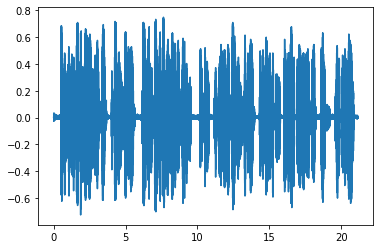

In [6]:
# plot audio over time
t = np.linspace(0, len(audio_data) / fs, len(audio_data))
plt.plot(t, audio_data)

In [7]:
# fw is fourier transform of audio (r in rfft means real input)
fw = np.fft.rfft(audio_data)
w = np.linspace(0, fs / 2, len(fw))

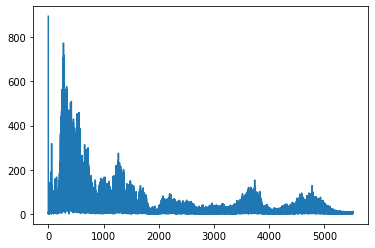

In [8]:
# plot fourier transform of the whole audio
plt.plot(w, np.abs(fw))

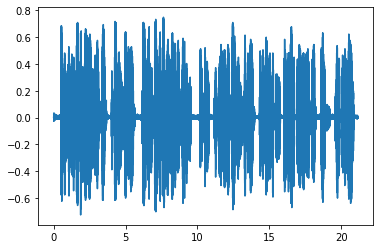

In [9]:
# plot inverse fourier transform to see everything is correct
inv_fw = np.fft.irfft(fw)
plt.plot(t, inv_fw)

In [10]:
# n_width is window width and n_overlap is window overlap (in samples)
def get_window_generator(signal, n_width, n_overlap):
    index = 0
    original_length = len(signal)
    
    while True:
        start_pos = (n_width - n_overlap) * index
        stop_pos = start_pos + n_width # last index is excluded
        
        if start_pos > original_length:
            break

        # pad signal with zeros if stop_pos has exceeded signal length
        if stop_pos > original_length:
            delta = stop_pos - original_length
            signal = np.pad(signal, (0, delta), 'constant')

        chunk = signal[start_pos:stop_pos]
        window = abs(np.fft.rfft(chunk))

        # yield normalized array
        yield window / linalg.norm(window)
        
        index = index + 1

In [11]:
n_width = 1024
n_overlap = n_width // 2
windows = get_window_generator(audio_data, n_width, n_overlap)

# create array which will have fourier transforms in it
fts = []
for w in windows:
    fts.append(w)

# transpose matrix so its columns are fourier transforms (for easier plotting)
fts = np.array(fts).T

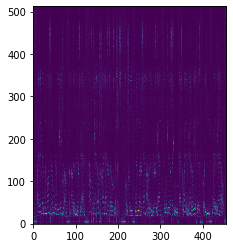

In [12]:
# plot current figure, doesn't look like much yet
plt.imshow(fts, origin='lower')

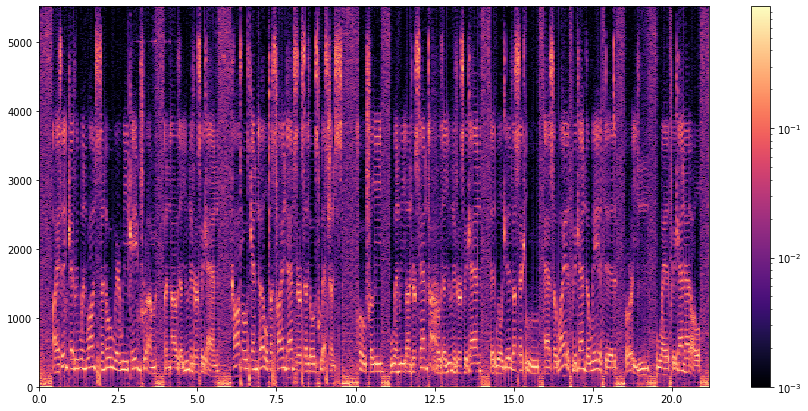

In [13]:
plt.figure(figsize=(15, 7))

# compute x and y max values
x_max = fts.shape[1] * (n_width - n_overlap) / fs
y_max = fs / 2

# define epsilon - number to which the darkest color maps
eps = 0.001

# plot spectrogram with logarithmic scale
plt.imshow(fts, 
           origin='lower', 
           aspect='auto', 
           extent=[0, x_max, 0, y_max], 
           interpolation='nearest', 
           norm=colors.LogNorm(vmin=eps, vmax=fts.max()),
           cmap='magma') # useful cmaps: inferno, amfhot, magma, viridis

plt.colorbar(None, use_gridspec=True)

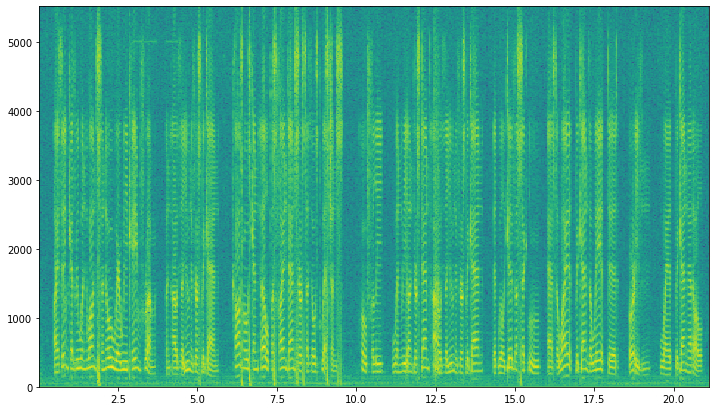

In [14]:
# plot spectrogram with matplotlib library and confirm that our result is similar (at the time my plot has some problems)
plt.figure(figsize=(12, 7))
plt.specgram(audio_data, NFFT=n_width, Fs=fs, noverlap=n_overlap);